In [1]:
import numpy as np
import scipy.io
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

In [2]:
# Load cbcl 
mat = scipy.io.loadmat('cbcl_cropped.mat')

(324, 2900)
(2900, 18, 18, 1)
tf.Tensor([2900   18   18    1], shape=(4,), dtype=int32)
tf.Tensor([ 1 18 18  1], shape=(4,), dtype=int32)
(18, 18)


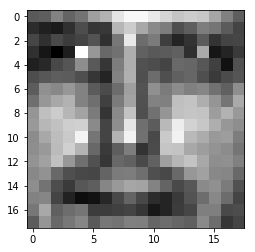

In [684]:
# Preprocess Data (reshape and show example image)
X = mat['Z']
print(np.shape(X))
X = np.reshape(X, [1,18,18,2900])
X = np.transpose(X, axes=(3,1,2,0))
X = np.rot90(X, k=3, axes=(1, 2))

BUFFER_SIZE = 60000
BATCH_SIZE = 5

print(np.shape(X))

X = tf.convert_to_tensor(X)
print(tf.shape(X))

ex_im = tf.slice(X, begin=[0,0,0,0],size =[1,18,18,1])
print(tf.shape(ex_im))

print(np.shape(ex_im[0,:,:,0]))
plt.imshow(ex_im[0,:,:,0], cmap='gray')


In [372]:
# Create generator network
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(3*3*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((3, 3, 256)))
    assert model.output_shape == (None, 3, 3, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 6, 6, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False))
    assert model.output_shape == (None, 18, 18, 64)
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 18, 18,1)
    
#     model.add(Reshape((18,18)))
#     model.add(Flatten())
    
#     model.add(Softmax())

    return model

tf.Tensor([ 2 18 18  1], shape=(4,), dtype=int32)


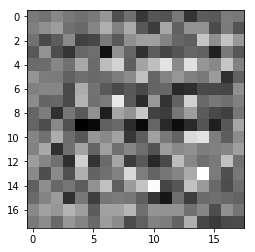

In [373]:
generator = make_generator_model()

noise = tf.random.normal([2, 100])
generated_image = generator(noise, training=False)
print(tf.shape(generated_image))

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [374]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=(18,18,1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [375]:
discriminator = make_discriminator_model()
decision_1 = discriminator(generated_image)
# indx = 17;
# print(type(indx))
# print(X)
decision_2 = discriminator(ex_im)
print(decision_1, decision_2)

tf.Tensor(
[[0.00125863]
 [0.00221789]], shape=(2, 1), dtype=float32) tf.Tensor([[0.01650321]], shape=(1, 1), dtype=float32)


In [376]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [377]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [378]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [379]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [380]:
train_images = X
# train_images = train_images.reshape(train_images.shape[0], 18, 18, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [381]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)
# seed = tf.random.normal([num_examples_to_generate, noise_dim])

<BatchDataset shapes: (None, 18, 18, 1), types: tf.float64>


In [382]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [425]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print('Epoch = ', epoch)
        for image_batch in dataset:
          train_step(image_batch)
    print('End')


In [426]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [743]:
train(train_dataset,50)

Epoch =  0
Epoch =  1
Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Epoch =  40
Epoch =  41
Epoch =  42
Epoch =  43
Epoch =  44
Epoch =  45
Epoch =  46
Epoch =  47
Epoch =  48
Epoch =  49
End


tf.Tensor([10000    18    18     1], shape=(4,), dtype=int32)


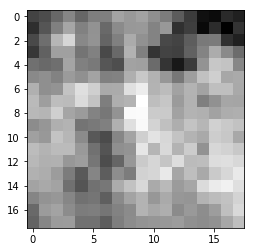

In [744]:
noise = tf.random.normal([10000, 100], 1, 10)
generated_image = generator(noise, training=False)
print(tf.shape(generated_image))

# vec = np.sor(np.rand)

# for i in range(10):
plt.imshow(generated_image[1,:,:,0], cmap='gray')

In [754]:
# discriminator = make_discriminator_model()
decision_1 = discriminator(generated_image).numpy()
decision_1 = decision_1[:,0]
print(np.shape(decision_1))
# indx = 17;
# print(type(indx))
# print(X)
decision_1 = np.sign(decision_1)
count_1 = np.zeros(len(decision_1))

for i in range(len(decision_1)):
    if decision_1[i] == 1:
        count_1[i] = 1
        
accuracy_1 = sum(count_1)/len(count_1)
print(accuracy_1)

decision_2 = np.sign(discriminator(train_images).numpy())
decision_2 = decision_2[:,0]
print(np.shape(decision_2))
count_2 = np.zeros(len(decision_2))

for i in range(len(decision_2)):
    if decision_2[i] == 1:
        count_2[i] = 1

accuracy_2 = sum(count_2)/len(count_2)
print(accuracy_2)

(10000,)
0.2408
(2900,)
0.926896551724138


In [201]:
print(generated_image[388,:,:,0] - generated_image[138,:,:,0] )

tf.Tensor(
[[-0.44224232 -0.44049457 -0.3595942  -0.40082726 -0.39818287 -0.52027565
  -0.37104088 -0.37536383 -0.3410018  -0.35946435 -0.3340733  -0.377038
  -0.32816923 -0.32023168 -0.35990408 -0.4204599  -0.46819538 -0.6359366 ]
 [-0.37169385 -0.33188525 -0.24183676 -0.25675943 -0.32094237 -0.43068627
  -0.49026215 -0.5733881  -0.4311325  -0.35654455 -0.34114522 -0.25252855
  -0.19732267 -0.22223389 -0.2217834  -0.22273573 -0.39458445 -0.5439453 ]
 [-0.31498587 -0.3717054  -0.33308098 -0.35680902 -0.29884416 -0.4440096
  -0.4558519  -0.45394933 -0.39014733 -0.3924275  -0.25224602 -0.33072838
  -0.28765783 -0.31790176 -0.30437243 -0.33542407 -0.38316387 -0.43678197]
 [-0.52253604 -0.47650093 -0.4585018  -0.45319226 -0.47697532 -0.54623556
  -0.50033116 -0.4120406  -0.29116684 -0.35855943 -0.40696275 -0.4662715
  -0.48270682 -0.42971724 -0.44785938 -0.46362644 -0.40361825 -0.43232664]
 [-0.3537228  -0.35821822 -0.23936976 -0.43363658 -0.49926245 -0.56984144
  -0.3933825  -0.3518269  -